# Going Back-to-Basics
## Linear methods for regression

In [238]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#from linear_regression import linear_regression  as lr 
from sklearn import datasets
import pandas as pd

In this series of back-to-basic posts I'm reviews some simpler but powerful inferential statistical methods. Here we're focusing on the good ol'fashion linear regression. In the next post I'll dive into some shrinkage techniques but for now we're keeping it simple. The last cell contains all the code in the linear regression class.

I'm using the [prostate data](https://web.stanford.edu/~hastie/ElemStatLearn/data.html) set following my favorite machine learning text, [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/). 

Linear regressions is the minimization of a cost function $E[(Y-\hat{Y})^2]$ where $\hat{Y} = X\beta$ where $\beta$ are the estimated regression coefficients and $X$~is a $(p+1)\times~N$ matrix containing p predictors and N data points. The expectation is taken empirically.








The regression is calculated by optimizing the coefficients, $\hat{\beta}$ to minimize the cost (RSS),


$$
RSS = (Y-\beta X)^T(Y-\beta X)\\
= Y^TY  - Y\beta X - YX^T\beta^T +X^T\beta^T\beta X,\\
\nabla_{\beta} RSS = 0  \\
= -2X^TY  + 2 X^TX\beta\\
\rightarrow \hat{\beta} = (X^TX)^{-1}X^T\beta
$$

To avoid computing $(X^T X)^{-1}$ directly, X is decomposed into $X = QR$ via QR-decomposition. The solutions become:

$$
\hat{\beta} = R^{-1} Q^T y\\
\hat{y} = QQ^T y
$$

Because R is upper triangular, it's easier to invert.
This is implemented in the gs_solver method below.




To check for collinearity between predictors, the variance inflation factor is calculated as:

$$
VIF(\hat{\beta}_j) = \frac{1}{1-R^2_j}
$$


where $R^2_j$ is the RSS of a regression of $x_i$ on all of the other predictors. The rule of thumb is a VIF larger than 10 is an indicator for a collinear predictor.


In [260]:
import numpy as np
import matplotlib.pyplot as plt

class linear_regression(object):
    def __init__(
            self,
            predictors,
            X,
            Y,
            X_test,
            Y_test,
            standardize=True,
            intercept=True,
            weighted=False):
        '''
            Initalize linear regression object
            with the dataset
            X = (P+1/P, N) dim matrix
            Y = N dim vector
            input: Standardize [bool](whiten data)
            intercept [bool](Include intercept in model)
        '''
        if standardize and intercept:
            X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
            X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)
            X = np.hstack((X, np.ones((X.shape[0], 1))))
            X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
            predictors.append('intercept')
        elif standardize and not intercept:
            X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
            X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)
            Y = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)
        elif not standardize and intercept:
            X = np.hstack((X, np.ones((X.shape[0], 1))))
            predictors.append('intercept')
        # initalized
        self.predictors = predictors
        self.X = X
        self.Y = Y
        self.X_test = X_test
        self.Y_test = Y_test


    def solve(self, solver='Simple', weighted=False, verbose = True):
        '''
            Solve regression directly or
            with Successive Gram-Schmidt Orthonormalization
            solver:  "Simple", 'gs' [str] (solution method)
            weighted [bool](Weighted OLS)
            returns a dataframe with
        '''
        if solver == 'Simple':
            ret = self.solve_simple()
        elif solver == 'gs':
            ret = gs_solver()
        RSS = self._RSS()
        rsq = self.r_squared()
        self.z_score = self.zscore()
        if verbose:
            print(f"***** {solver} Least-Squares Estimate")
            print(
                '{:<10.10s}{:<10.8s}{:<10.8s}{:<10.8s}'.format(
                    "Predictor",
                    "Coef.",
                    "Std. err.",
                    "Z-score"))

            dash = '-' * 40
            print(dash)
            for i in range(len(self.predictors)):
                print(
                    '{:<10.8s}{:>10.3f}{:>10.3f}{:>10.3f}'.format(
                        self.predictors[i],
                        self.beta[i][0],
                        self.beta[i][0],
                        self.z_score[i]))
            print(f"***** R^2: {rsq}")

    def solve_simple(self, weighted=False):
        '''
            Direct least-squares solution.
            b = (XtX)^-1XTY
            yhat = xb
        '''
        self.invxtx = np.linalg.inv(self.X.T @ self.X)
        beta = self.invxtx @ self.X.T @ self.Y
        y_hat = self.X @ beta
        self.beta = beta
        self.y_hat = y_hat
        return beta, y_hat

    def gs_solver(self, weighted=False):
        '''
            Gram-Schmidt Orthogonalization:
            using QR decomposition
            Note: QR decomp required Np^2 operations
            R - Upper traingular matrix
            Q - Note: np.linalg.qr is doing the heavy lifting
        '''
        Q, R = np.linalg.qr(self.X)
        self.beta = np.linalg.inv(R) @ Q.T @ self.Y
        self.y_hat = Q.T @ Q @ self.U
        return self.beta, self.y_hat

    def zscore(self, weighted=False):
        '''
            Z-score
            For the jth predictor
            z_j = beta_hat_j / (sqrt(var * v_j))
            where v = (X.T*X)_jj
        '''
        v = np.diag(self.invxtx)
        var = self._var()
        return np.ravel(self.beta)/(np.sqrt(var)*np.sqrt(v))

    def _RSS(self, weighted=False):
        '''
            Multivariate RSS Calculation
        '''
        self.rss = None
        err = self.Y - self.y_hat
        if weighted:
            self.rss = np.trace(err.T @ np.cov(err) @ err)
        else:
            self.rss = np.trace(err.T @ err)
        return self.rss

    def r_squared(self):
        '''
            Multivariate RSS Calculation
        '''
        if self.rss:
            tss = np.sum((self.Y - np.mean(self.Y))**2)
            return 1 - self.rss/tss
        else:
            return None

    def _var(self, weighted=False):
        '''
            Returns an unbiased estimate of the sample variance sigma^2
            sigma^1 = 1/(N-p-1) * MSE
        '''
        N, p = self.X.shape
        return 1 / (N - p - 1) * np.sum((self.Y - self.y_hat)**2)


    def pred_error(self, beta):
        '''
            Returns the MSE of an estimate
        '''
        y_pred = self.X_test @ beta
        return np.sum((y_pred - self.Y_test)**2)


    def backwards_stepwise_selection(self, plot=False,fname=None):
        '''
            returns a list of variables dropped during each iterations
        '''
        import copy
        #regress on the full model, then drop the predictor with the smallest
        #z-score
        x_prev, y_prev = self.X.copy(), self.Y.copy()
        x_test_prev  = self.X_test.copy()
        pred_prev = self.predictors.copy()
        rssarr, p_dropped = [], []
        prederr  = []
        for i in range(len(self.predictors)-1):
            self.solve(verbose = False)
            min_idx = np.argmin(np.abs(self.z_score))
            p_dropped.append(self.predictors[min_idx])
            rssarr.append(self.rss)
            prederr.append(self.pred_error(self.beta))
            #delete column
            self.X = np.delete(self.X,min_idx,axis=1)
            self.X_test = np.delete(self.X_test,min_idx,axis=1)
            self.predictors = np.delete(self.predictors,min_idx,axis=0)

        self.X = x_prev
        self.Y = y_prev
        self.X_test = x_test_prev
        self.predictors = pred_prev

        return p_dropped, prederr

    
    def _variance_inflation_factor(self):
        '''
            Calculate the Variance inflation factor
            (1/(1-RSS_i)) where i is the ith feature
            regressed on the remaining features in the dataset
            Outputs a table of the variance inflaction factor
            to stdout
        '''
        x_test_prev  = self.X_test.copy()
        self.X = np.delete(self.X,len(self.predictors)-1,axis=1)
        x_prev, y_prev = self.X.copy(), self.Y.copy()
        #drop the predictor column
        vif = []
        for i in range(len(self.predictors)-1):
            self.Y = self.X[:,i].copy().reshape((-1,1))
            self.X = np.delete(self.X,i,axis=1)
            self.solve(verbose = False)
            rs = self.r_squared()
            vif.append(1.0/(1.0-rs))
            self.X = x_prev
        #reset dataset 
        self.X = x_prev
        self.Y = y_prev
        
        print("Variance Inflation factor")
        for i in range(len(self.predictors)-1):
            print('{:<10.8s}{:>10.3f}'.format(
                self.predictors[i],
                vif[i]))


In [261]:
##testing with the prostate dataset
df = pd.read_csv('./prostate.data',sep='\s+')
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


By peaking at the dataset(above), we see a mixture of catagorical and continious data. Luckly, this dataset is a toy-model, catagorical variables are encoded by an index and the data has been cleaned. Training and testing data has already been labeled which is split in the code-cell below.

In [262]:
#split train and test
df_train = df.loc[df['train'] == 'T']
df_test = df.loc[df['train'] == 'F']
#drop train column
df_train = df_train.drop(['train'],axis=1)
df_test = df_test.drop(['train'],axis=1)
x_train = df_train[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']].to_numpy()
y_train = df_train[['lpsa']].to_numpy()
x_test = df_test[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']].to_numpy()
y_test = df_test[['lpsa']].to_numpy()
predictors = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']

In [263]:
#plot correlations between all predictors
#grr = pd.plotting.scatter_matrix(df, figsize=(15, 15), marker='o',
#                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

In [264]:
fh = linear_regression(predictors, x_train, y_train, x_test, y_test, standardize = True, intercept=True)
fh.solve()

***** Simple Least-Squares Estimate
Predictor Coef.     Std. err  Z-score   
----------------------------------------
lcavol         0.711     0.711     5.320
lweight        0.290     0.290     2.727
age           -0.141    -0.141    -1.384
lbph           0.210     0.210     2.038
svi            0.307     0.307     2.448
lcp           -0.287    -0.287    -1.851
gleason       -0.021    -0.021    -0.145
pgg45          0.275     0.275     1.723
intercep       2.452     2.452    27.938
***** R^2: 0.6943711796768238


['gleason', 'age', 'lcp', 'pgg45', 'lbph', 'svi', 'lweight', 'lcavol']

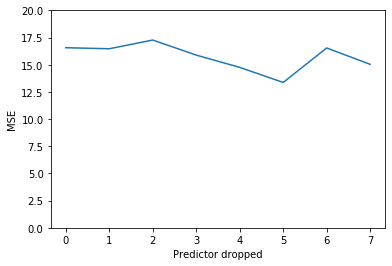

In [265]:
p_dropped, prederr = fh.backwards_stepwise_selection()
fig, ax = plt.subplots()

plt.plot(np.arange(len(prederr)),prederr)
plt.ylim(0,20)
plt.xlabel("Predictor dropped")
plt.ylabel("MSE")
p_dropped

In [266]:
fh._variance_inflation_factor()

Variance Inflation factor
lcavol         2.318
lweight        1.472
age            1.357
lbph           1.383
svi            2.045
lcp            3.117
gleason        2.644
pgg45          3.313
